In [1]:
import numpy as np
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.preprocess.utils import (
    overlay,
    enhance_contrast,
    normalize_img_to_uint8,
)
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pathlib import Path
import pandas as pd

## Convert Labelme Json to COCO Json

run the following code once for generating coco json
```
import livecell_tracker.segment
import livecell_tracker.annotation
import livecell_tracker.annotation.labelme2coco
import os
labelme_json_folder = r"""../datasets/a549_ccnn/annotation_data"""
dataset_folder_path = r"""../datasets/a549_ccnn/original_data"""
export_dir = "./notebook_results/correction_cnn_v0.0.0/"
os.makedirs(export_dir, exist_ok=True)
livecell_tracker.annotation.labelme2coco.convert(
    labelme_json_folder,
    export_dir,
    train_split_rate=0.9,
    dataset_folder_path=dataset_folder_path,
    # is_image_in_json_folder=True,
    image_file_ext="tif",
    # image_file_ext="png",
)
```

## Load COCO into SingleCell Objects

In [2]:
from pycocotools.coco import COCO

coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/train.json")
out_dir = Path("./notebook_results/a549_ccp_vim/train_data_v6/")
# coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/val.json")
# out_dir = Path("./notebook_results/a549_ccp_vim/test_data_v6/")

coco_data.anns.keys(), coco_data.anns[1].keys(), coco_data.anns[1]["segmentation"][0][
    :5
]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [3]:
coco_data.imgs.keys(), coco_data.imgs[1].keys(), coco_data.imgs[1]["file_name"],


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 dict_keys(['height', 'width', 'id', 'file_name']),
 '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile7_DIC-FITC.tif')

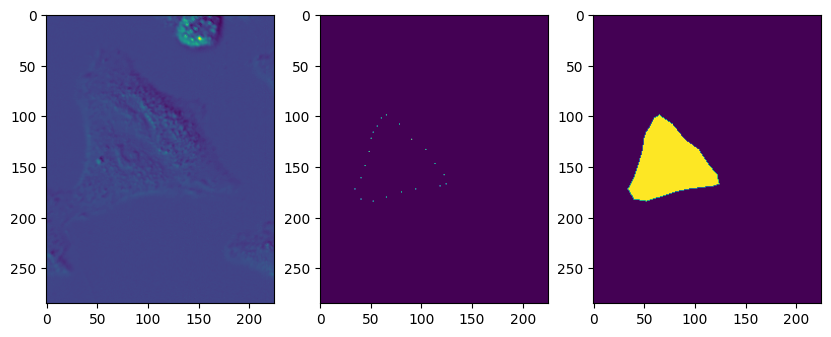

In [4]:
from typing import List

from livecell_tracker.annotation.coco_utils import coco_to_sc

single_cells = coco_to_sc(coco_data)


# # for testing
# single_cells = single_cells[:20]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
cell_id = 10
axes[0].imshow(single_cells[cell_id].get_img_crop(padding=100))
axes[1].imshow(single_cells[cell_id].get_contour_mask_closed_form(padding=100))
axes[2].imshow(single_cells[cell_id].get_contour_mask(padding=100))


In [5]:
len(single_cells)

294

save a list of single cell objects

In [6]:
SingleCellStatic.write_single_cells_json(
    single_cells, "../datasets/a549_ccnn/single_cells.json"
)


In [7]:
contour_mask = single_cells[cell_id].get_contour_mask(padding=100)
contour_mask.astype(np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

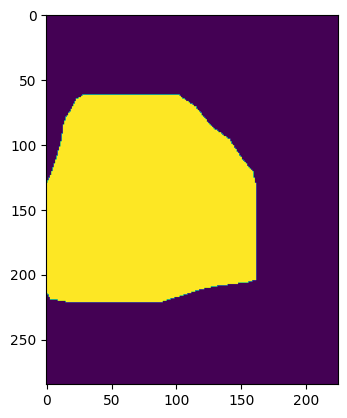

In [8]:
import cv2 as cv
from livecell_tracker.preprocess.utils import dilate_or_erode_mask

plt.imshow(dilate_or_erode_mask(contour_mask.astype(np.uint8), 1))


In [9]:
sample_sc = single_cells[cell_id]
sample_sc.meta

{'img_id': 7,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile8_DIC-FITC.tif'}

In [10]:
import glob

raw_img_dataset = sample_sc.img_dataset
seg_data_dir = "../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11"
seg_paths = glob.glob(os.path.join(seg_data_dir, "*.png"))
print("sample seg paths:", seg_paths[:2])
matched_time2seg = {}
# for time, img_path in raw_img_dataset.time2url.items():
#     substr = os.path.basename(img_path).split(".")[0]
#     print("substr:", substr)
#     for seg_path
#     break
corrected_indices = []
for seg_path in seg_paths:
    substr = os.path.basename(seg_path).split(".")[0] # get rid of extension
    substr = substr[4:]  # get rid of seg_ prefix
    img, path, index = raw_img_dataset.get_img_by_url(
        substr, return_path_and_time=True, ignore_missing=True
    )
    if path is None:
        print("skip due to substr not found:", substr)
        continue
    matched_time2seg[index] = seg_path

seg_data = LiveCellImageDataset(time2url=matched_time2seg, ext="png")
sample_sc.mask_dataset = seg_data
assert len(seg_data) == len(raw_img_dataset)

for sc in single_cells:
    assert sc.timeframe in seg_data.time2url
    sc.mask_dataset = seg_data

sample seg paths: ['../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY2_DIC_tile8_DIC-FITC.png', '../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile0_DIC-FITC.png']
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY2_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile2_DIC-FITC
skip due to substr not fo

## Generate Synthetic Undersegmentation data

<AxesSubplot: >

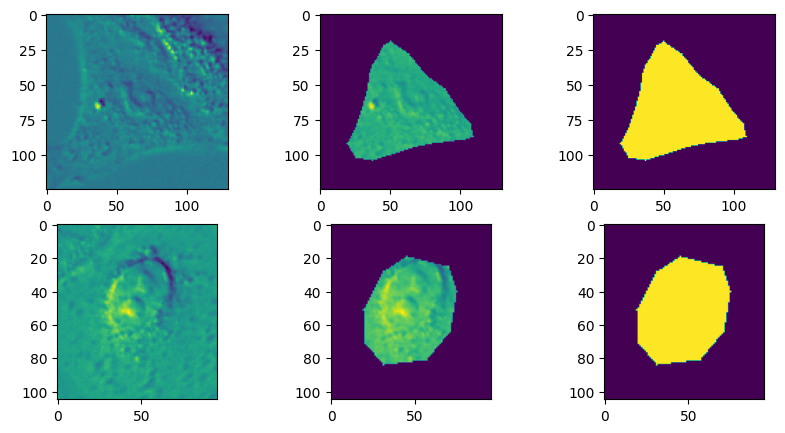

In [11]:
sc1 = single_cells[10]
sc2 = single_cells[1]

padding=20
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
sc1.show(padding=padding, ax=axes[0][0])
sc1.show_contour_img(padding=padding, ax=axes[0][1])
sc1.show_contour_mask(padding=padding, ax=axes[0][2])
sc2.show(padding=padding, ax=axes[1][0])
sc2.show_contour_img(padding=padding, ax=axes[1][1])
sc2.show_contour_mask(padding=padding, ax=axes[1][2])

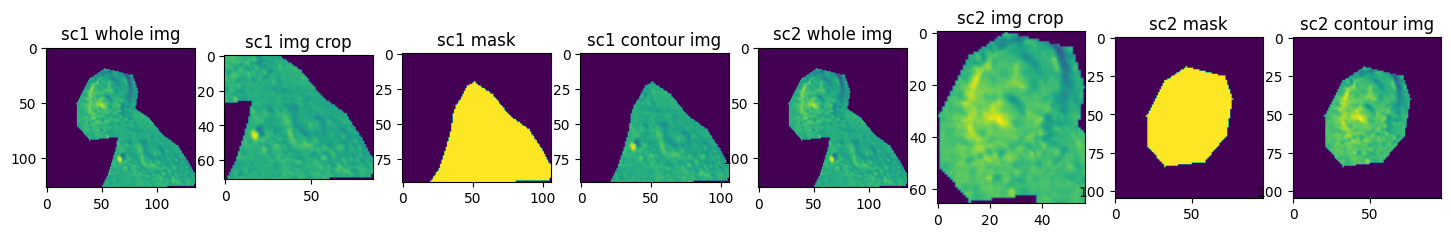

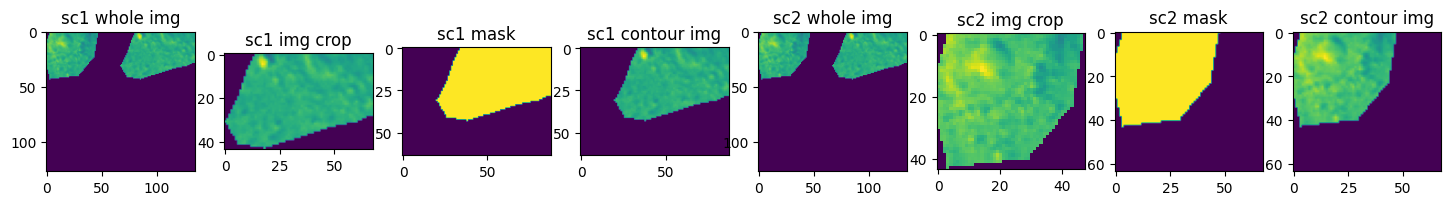

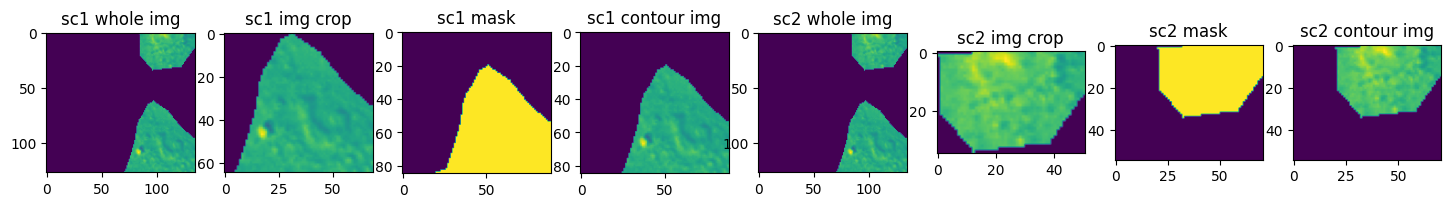

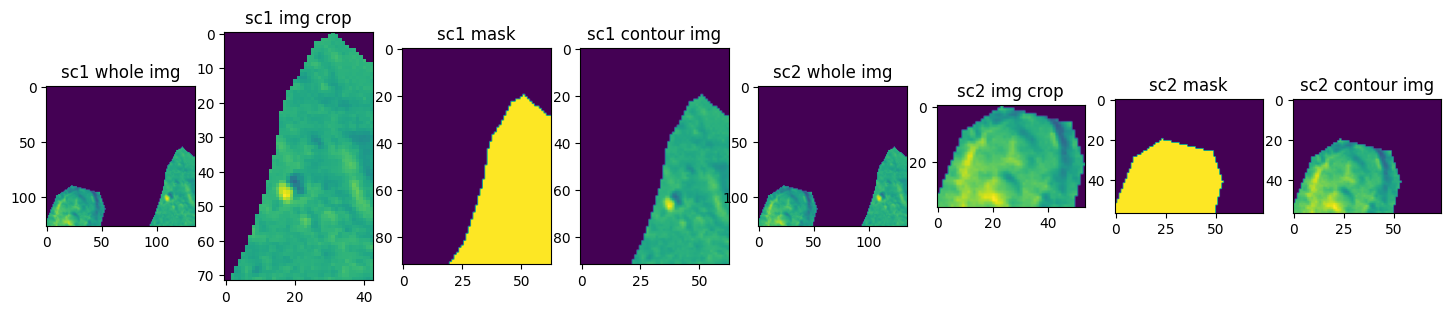

In [12]:
from livecell_tracker.core.datasets import SingleImageDataset


def check_contour_in_boundary(contour, boundary):
    return np.all(contour >= 0) and np.all(contour < boundary)


def adjust_contour_to_bounds(contour, bounds):
    if not check_contour_in_boundary(contour, bounds):
        contour = contour.copy()
        contour[contour < 0] = 0
        contour = np.where(contour >= bounds, bounds - 1, contour)
    return contour

def shift_contour_randomly(sc_center, contour, bounds):
    random_center = np.random.randint(low=0, high=bounds, size=2)
    shift = random_center - sc_center
    shift = shift.astype(int)
    contour_shifted = contour + shift
    return random_center, contour_shifted, shift

def compute_two_contours_min_distance(contour1, contour2):
    min_dist = np.inf
    for p1 in contour1:
        for p2 in contour2:
            dist = np.linalg.norm(p1 - p2)
            if dist < min_dist:
                min_dist = dist
    return min_dist

def combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, bg_scale=1.5, fix_sc1=False):
    def _gen_empty_bg_img():
        sc1_shape = sc1.get_img_crop().shape
        sc2_shape = sc2.get_img_crop().shape
        bg_shape = np.array([max(sc1_shape[0], sc2_shape[0]), max(sc1_shape[1], sc2_shape[1])])
        bg_shape = (bg_shape * bg_scale).astype(int)
        bg_img = np.zeros(shape=bg_shape)
        return bg_img
    
    if bg_img is None:
        bg_img = _gen_empty_bg_img()

    bg_shape = np.array(bg_img.shape)
    new_img = bg_img.copy()
    new_mask = np.zeros(shape=bg_shape, dtype=bool)

    def _add_sc_to_img_helper(sc, new_img, new_sc_mask, shift, in_place=False):
        if not in_place:
            new_img = new_img.copy()
        sc_ori_space_pixel_xy_arr = np.array(new_sc_mask.nonzero()).T - shift
        sc_ori_space_pixel_xy_arr[sc_ori_space_pixel_xy_arr < 0] = 0
        new_img[new_sc_mask] = sc.get_contour_img()[sc_ori_space_pixel_xy_arr[:, 0], sc_ori_space_pixel_xy_arr[:, 1]]
        return new_img

    def add_sc_to_img(sc, new_img, mask, in_place=False, mask_inplace=True, fix_sc_pos=False):
    
        sc_prop = sc.compute_regionprops()
        sc_contour_coords = sc.get_contour_coords_on_crop().astype(int)
        if fix_sc_pos:
            sc_new_center = sc_prop.centroid
            sc_new_contour = sc_contour_coords
            shift = 0
        else:
            sc_new_center, sc_new_contour, shift = shift_contour_randomly(sc_prop.centroid, sc_contour_coords, bounds=bg_shape)
        sc_new_contour = adjust_contour_to_bounds(sc_new_contour, bg_shape)
        new_sc_mask = SingleCellStatic.gen_contour_mask(sc_new_contour, bg_img, bbox=None)
        new_sc_mask_bool = new_sc_mask > 0 # convert to bool
        new_img = _add_sc_to_img_helper(sc, new_img, new_sc_mask, shift, in_place=in_place)

        if mask_inplace:
            mask = mask.copy()
        mask[new_sc_mask_bool] = True
        return new_img, sc_new_contour, mask, shift

    _, sc1_new_contour, sc1_new_mask, shift1 = add_sc_to_img(sc1, new_img, mask=new_mask, in_place=True, fix_sc_pos=fix_sc1)
    _, sc2_new_contour, sc2_new_mask, shift2 = add_sc_to_img(sc2, new_img, mask=new_mask, in_place=True)

    new_sc1 = SingleCellStatic(timeframe=SingleImageDataset.DEFAULT_TIME, contour=sc1_new_contour, img_dataset=SingleImageDataset(new_img), mask_dataset=SingleImageDataset(sc1_new_mask))
    new_sc2 = SingleCellStatic(timeframe=SingleImageDataset.DEFAULT_TIME, contour=sc2_new_contour, img_dataset=SingleImageDataset(new_img), mask_dataset=SingleImageDataset(sc2_new_mask))
    return new_sc1, new_sc2

# has_overlap = np.any(new_sc1_mask & new_sc2_mask)
# print(has_overlap)
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# ax = axes[0][0]
# ax.imshow(new_sc1_mask | new_sc2_mask)
# ax = axes[0][1]
# ax.imshow(new_img)
bg_scale = 3.0

def viz_check_combined_sc_result(sc1, sc2):
    fig, axes = plt.subplots(1, 8, figsize=(18, 5))
    ax_idx = 0
    ax = axes[ax_idx]
    sc1.show_whole_img(ax=ax)
    ax.set_title("sc1 whole img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show(ax=ax)
    ax.set_title("sc1 img crop")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show_mask(ax=ax, padding=20)
    ax.set_title("sc1 mask")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show_contour_img(ax=ax, padding=20)
    ax.set_title("sc1 contour img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_whole_img(ax=ax)
    ax.set_title("sc2 whole img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show(ax=ax)
    ax.set_title("sc2 img crop")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_mask(ax=ax, padding=20)
    ax.set_title("sc2 mask")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_contour_img(ax=ax, padding=20)
    ax.set_title("sc2 contour img")
    ax_idx += 1

    plt.show()

for i in range(4):
    new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None)
    viz_check_combined_sc_result(new_sc1, new_sc2)

# for i in range(4):
#     new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, fix_sc1=True)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

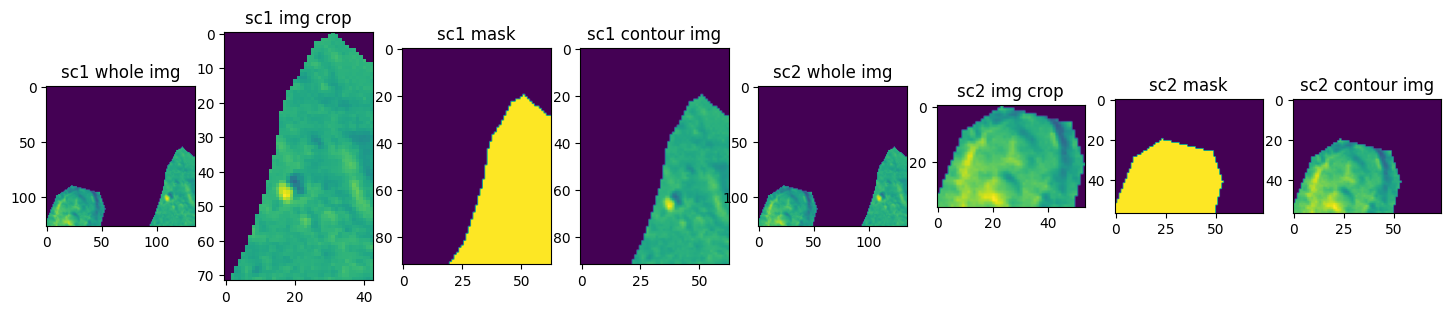

In [13]:
viz_check_combined_sc_result(new_sc1, new_sc2)

  0%|          | 0/4 [00:00<?, ?it/s]

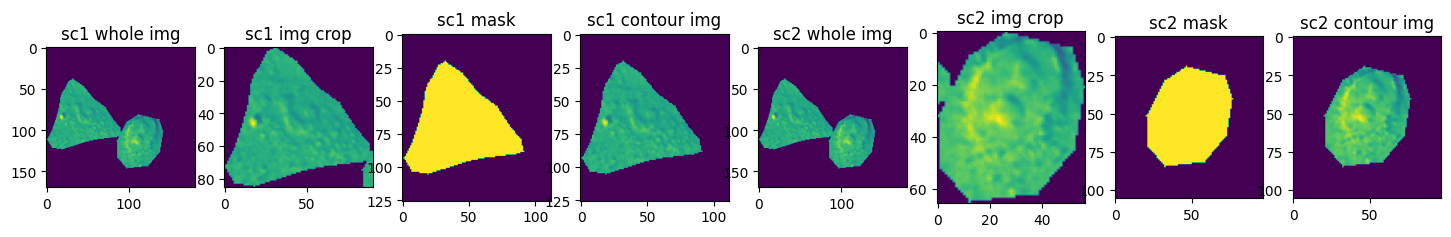

 25%|██▌       | 1/4 [00:01<00:03,  1.20s/it]

In [14]:
def gen_synthetic_overlap_scs(sc1, sc2, max_overlap_percent=0.2, bg_scale=2.0, fix_sc1=False, min_area_percent = 0.4, max_try=1000):
    # TODO: optimize in the future via computational geometry; now simply use monte carlo for generating required synthetic data
    is_success = False
    counter = 0
    while not is_success and counter < max_try:
        is_success = True
        new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, bg_scale=bg_scale, fix_sc1=fix_sc1)
        # check overlap
        overlap_mask = np.logical_and(new_sc1.get_mask(), new_sc2.get_mask())
        overlap_percent = float(np.sum(overlap_mask)) / min(np.sum(new_sc1.get_mask()), np.sum(new_sc2.get_mask()))
        if overlap_percent > 0 and overlap_percent < max_overlap_percent:
            pass
        else:
            is_success = False

        # check area percent to prevent scs that are too small
        area = float(np.sum((new_sc1.get_contour_mask()>0).flatten())) + np.sum((new_sc2.get_contour_mask()>0).flatten())
        old_area = float(np.sum((sc1.get_contour_mask()>0).flatten())) + np.sum((sc2.get_contour_mask()>0).flatten())
        if (area / old_area)  < min_area_percent:
            is_success = False
        counter += 1

    return new_sc1, new_sc2, overlap_percent, is_success


def gen_synthetic_nonoverlap_scs(min_dist=10, max_dist=100, n=10, ):
    pass


# check results
for i in tqdm(range(4)):
    new_sc1, new_sc2, _, is_success = gen_synthetic_overlap_scs(sc1, sc2)
    viz_check_combined_sc_result(new_sc1, new_sc2)

In [ ]:
from typing import Tuple
from skimage.measure import regionprops
import pandas as pd
from livecell_tracker.core.io_utils import save_tiff


def underseg_overlay_gt_masks(
    seg_label: int, scs: SingleCellStatic, padding_scale=1.5, seg_mask=None
) -> Tuple[np.array, np.array, np.array]:
    """Overlay segmentation masks and ground truth masks for under-segmentation cases.
    Specifically, for a segmentation label, if there are multiple ground truth masks matched to it,
    then we overlay ground truths masks in the same kmask

    Parameters
    ----------
    seg_label : int
        _description_
    scs : SingleCellStatic
        _description_
    padding_scale : float, optional
        _description_, by default 1.5
    mask :
        if not None, use the mask, otherwise inferred from other args, by default None

    Returns
    -------
    Tuple[np.array, np.array, np.array]
        (img_crop, seg_crop, combined ground-truth mask)
    """
    if len(scs) == 0:
        print("no scs for this seg_label")
        return None, None, None

    if seg_mask is None:
        seg_mask = scs[0].get_mask()

    seg_mask[seg_mask != seg_label] = 0
    props_list = regionprops(seg_mask)

    if len(props_list) != 1:
        print(
            "[WARNING] skip: (%d, %d) due to more than one region found in seg mask or NO region found in seg mask"
            % (img_id, seg_label)
        )
        return
    # obtain segmentation bbox from segmentation mask
    seg_props = props_list[0]
    seg_bbox = seg_props.bbox
    xmin, ymin, xmax, ymax = seg_bbox

    # compute padding based on scale
    padding_pixels = np.array((padding_scale - 1) * max(xmax - xmin, ymax - ymin))
    padding_pixels = padding_pixels.astype(int)

    # get seg mask's crop with single cell's get_mask_crop implementation for consistency
    tmp = np.array(scs[0].bbox)
    scs[0].bbox = seg_bbox
    seg_crop = scs[0].get_mask_crop(padding=padding_pixels)
    scs[0].bbox = np.array(tmp)

    # clear other seg labels
    seg_crop[seg_crop != seg_label] = 0
    seg_crop[seg_crop > 0] = 1

    combined_gt_mask = np.zeros(seg_crop.shape)
    img_crop = None
    for idx, sc in enumerate(scs):
        sc.meta["seg_label"] = None
        tmp = np.array(sc.bbox)
        sc.bbox = seg_bbox
        combined_gt_mask += (idx + 1) * sc.get_contour_mask(padding=padding_pixels)
        img_crop = sc.get_img_crop(padding=padding_pixels) if img_crop is None else img_crop  # set img_crop once
        sc.bbox = tmp
    return (img_crop, seg_crop, combined_gt_mask)


def gen_aug_diff_mask(aug_mask: np.array, combined_gt_mask: np.array) -> np.array:
    """generate a mask based on the difference between the augmented mask and the combined gt mask
    0: no difference
    -1: augmented mask is 0, combined gt mask is 1 -> over-segmentation
    1: augmented mask is 1, combined gt mask is 0 -> under-segmentation
    Note: special care for uint8 case when calculating difference mask if we use cv2 related functions

    Parameters
    ----------
    aug_mask : np.array
        _description_
    combined_gt_mask : np.array
        _description_

    Returns
    -------
    np.array
        _description_
    """
    aug_mask = aug_mask.astype(int)  # prevent uint8 overflow (-1 in diff case below)
    underseg_mask = np.zeros(aug_mask.shape)
    underseg_mask[combined_gt_mask > 0] = 1
    combined_gt_mask = combined_gt_mask.astype(int)
    diff_mask = aug_mask - combined_gt_mask  # should only contain 0 and 1
    assert len(np.unique(diff_mask)) <= 3

    return diff_mask


def csn_augment_helper(
    img_crop,
    seg_crop,
    combined_gt_label_mask,
    scale_factors: list,
    train_path_tuples: list,
    augmented_data: list,
    img_id,
    seg_label,
    gt_label,
    raw_img_path,
    seg_img_path,
    gt_img_path,
    gt_label_img_path,
    augmented_seg_dir,
    augmented_diff_seg_dir,
    filename_pattern="img-%d_seg-%d.tif",
    overseg_raw_seg_crop=None,
    overseg_raw_seg_img_path=None,
    raw_transformed_img_dir=None,
    df_save_path=None,
    normalize_img_uint8 = True,
):

    if normalize_img_uint8:
        img_crop = normalize_img_to_uint8(img_crop)
    combined_gt_binary_mask = combined_gt_label_mask > 0
    combined_gt_binary_mask = combined_gt_binary_mask.astype(np.uint8)

    save_tiff(img_crop, raw_img_path, mode="I")  # save to 32-bit depth signed integer
    save_tiff(seg_crop, seg_img_path)
    save_tiff(combined_gt_binary_mask, gt_img_path)
    save_tiff(combined_gt_label_mask, gt_label_img_path)

    if overseg_raw_seg_img_path is not None:
        save_tiff(overseg_raw_seg_crop, overseg_raw_seg_img_path)

    # append aug-%d to filename pattern
    filename_root, ext = os.path.splitext(filename_pattern)
    aug_filename_pattern = filename_root + "_aug-%d" + ext
    # dilate or erode segmentation mask
    for idx, scale in enumerate(scale_factors):
        augmented_seg_path = augmented_seg_dir / (aug_filename_pattern % (img_id, seg_label, idx))
        augmented_diff_seg_path = augmented_diff_seg_dir / (aug_filename_pattern % (img_id, seg_label, idx))

        if np.unique(seg_crop).shape[0] > 256:
            print("[WARNING] skip: (%d, %d) due to more than 256 unique seg labels" % (img_id, seg_label))
            continue
        seg_crop = seg_crop.astype(np.uint8)

        # seg_crop should only contains one label
        # TODO: the condition commented above should be a postcondition of underseg_overlay_gt_masks
        seg_crop[seg_crop > 0] = 1
        aug_seg_crop = dilate_or_erode_mask(seg_crop, scale_factor=scale)
        aug_values = np.unique(aug_seg_crop)
        assert len(aug_values) <= 2, "only two values should be present in aug masks"
        aug_seg_crop[aug_seg_crop > 0] = 1
        aug_seg_crop[aug_seg_crop < 0] = 0  # not necessary, check math
        save_tiff(aug_seg_crop, augmented_seg_path)

        aug_diff_mask = gen_aug_diff_mask(aug_seg_crop, combined_gt_binary_mask)
        save_tiff(aug_diff_mask, augmented_diff_seg_path, mode="I")

        raw_transformed_img_path = raw_transformed_img_dir / ("img-%d_seg-%d_aug-%d.tif" % (img_id, seg_label, idx))
        raw_transformed_img_crop = img_crop.copy().astype(int)
        raw_transformed_img_crop[aug_seg_crop == 0] *= -1
        save_tiff(raw_transformed_img_crop, raw_transformed_img_path, mode="I")

        train_path_tuples.append(
            (
                raw_img_path.as_posix(),
                augmented_seg_path.as_posix(),
                gt_img_path.as_posix(),
                seg_img_path.as_posix(),
                scale,
                augmented_diff_seg_path.as_posix(),
                gt_label_img_path.as_posix(),
                raw_transformed_img_path.as_posix(),
            )
        )

        augmented_data.append(
            {
                "img_id": img_id,
                "img_crop": img_crop,
                "seg_crop": seg_crop,
                "seg_label": seg_label,
                "gt_label": gt_label,
                "combined_gt_mask": combined_gt_binary_mask,
                "aug_seg_crop": aug_seg_crop,
                "aug_diff_mask": aug_diff_mask,
                "combined_gt_label_mask": combined_gt_label_mask,
                "raw_transformed_img_crop": raw_transformed_img_crop,
            }
        )
        # augmented_data[(img_id, seg_label)].append(
        #     (
        #         img_crop,
        #         seg_crop,
        #         combined_gt_mask,
        #         aug_seg_crop,
        #         aug_diff_mask,
        #         combined_gt_label_mask,
        #         raw_transformed_img_crop,
        #     )
        # )
    cols = ["raw", "seg", "gt", "raw_seg", "scale", "aug_diff_mask", "gt_label_mask", "raw_transformed_img"]
    df = pd.DataFrame(train_path_tuples, columns=cols)
    if df_save_path:
        if os.path.exists(df_save_path):
            df.to_csv(
                df_save_path,
                index=False,
                mode="a",
                header=False,
            )
        else:
            df.to_csv(df_save_path, index=False)
    return {
        "train_path_tuples": train_path_tuples,
        "augmented_data": augmented_data,
        "df": df,
    }


check sc areas 
```
for sc in single_cells:
    prop = sc.compute_regionprops()
    assert prop.area > 5
```

In [ ]:
import itertools
from skimage.measure import find_contours
import cv2

def show_cv2_contours(contours, img):
    im = np.expand_dims(img.astype(np.uint8), axis=2).repeat(3, axis=2) 
    for k, _ in enumerate(contours):
        im = cv.drawContours(im, contours, k, (0, 230, 255), 6)
    plt.imshow(im)
    plt.show()

def find_contours_opencv(mask) -> list:
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = list(contours)
    for i, contour in enumerate(contours):
        contour = np.array(contour)
        contour = contour[:, :, ::-1]
        contour = contour.reshape(-1, 2)
        contours[i] = contour
    return contours

def merge_two_scs(sc1: SingleCellStatic, sc2: SingleCellStatic):
    new_mask = np.logical_or(sc1.get_mask().astype(bool), sc2.get_mask().astype(bool))
    # plt.imshow(new_mask)
    # plt.show()
    # print(np.unique(new_mask))
    # contours = find_contours(new_mask, fully_connected="high")

    contours = find_contours_opencv(new_mask.astype(np.uint8))
    assert len(contours) != 0, "must contain at least one contour"
    if len(contours) > 1:
        print("WARNING: more than one contour found, return merge failure to the caller...")
        return None, False
    new_contour = contours[0]
    res_sc = SingleCellStatic(
        timeframe=SingleImageDataset.DEFAULT_TIME,
        contour=new_contour,
        img_dataset=sc1.img_dataset,
        mask_dataset=SingleImageDataset(new_mask),
    )
    return res_sc, True



def augment_and_save_merged_sc(sc: SingleCellStatic, scale_factors, scs, img_id, seg_label, syn_id, out_dir):
    # img_crop = sc.get_img_crop()
    # seg_crop = sc.get_mask_crop()

    # Note: do not use get_img_crop() and get_mask_crop() here, because we want to use the original image and mask
    # which are consistent across scs passed in
    img_crop = sc.get_img()
    seg_crop = sc.get_mask()

    syn_underseg_out_dir = out_dir
    raw_out_dir = syn_underseg_out_dir / "raw"
    seg_out_dir = syn_underseg_out_dir / "seg"
    gt_out_dir = syn_underseg_out_dir / "gt"
    gt_label_out_dir = syn_underseg_out_dir / "gt_label_mask"
    augmented_seg_dir = syn_underseg_out_dir / "augmented_seg"
    raw_transformed_img_dir = syn_underseg_out_dir / "raw_transformed_img"
    augmented_diff_seg_dir = syn_underseg_out_dir / "augmented_diff_seg"

    # makedirs
    all_dirs = [syn_underseg_out_dir, raw_out_dir, seg_out_dir, gt_out_dir, gt_label_out_dir, augmented_seg_dir, raw_transformed_img_dir, augmented_diff_seg_dir]
    for directory in all_dirs:
        if not directory.exists():
            print(">>> creating dir: ", directory)
            os.makedirs(directory, exist_ok=True)


    # generate combined gt label mask
    combined_gt_label_mask = sc.get_mask().astype(int)
    for i, tmp_sc in enumerate(scs):
        # mask = SingleCellStatic.gen_skimage_bbox_img_crop(sc.bbox, tmp_sc.get_mask())
        mask = tmp_sc.get_mask().astype(bool)
        combined_gt_label_mask[mask] = i + 1

    raw_img_path = raw_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    seg_img_path = seg_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_img_path = gt_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_label_img_path = gt_label_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))

    underseg_train_tuples = []
    augmented_data = []
    filename_pattern = "syn-underseg-img-%d_seg-%d.tif"
    res_dict = csn_augment_helper(img_crop=img_crop, 
        seg_crop=seg_crop, 
        combined_gt_label_mask=combined_gt_label_mask,
        overseg_raw_seg_crop=None,
        overseg_raw_seg_img_path=None,
        scale_factors=scale_factors,
        train_path_tuples=underseg_train_tuples,
        augmented_data=augmented_data,
        img_id=img_id,
        seg_label=syn_id,
        gt_label=-1,
        raw_img_path=raw_img_path,
        seg_img_path=seg_img_path,
        gt_img_path=gt_img_path,
        gt_label_img_path=gt_label_img_path,
        augmented_seg_dir=augmented_seg_dir,
        augmented_diff_seg_dir=augmented_diff_seg_dir,
        filename_pattern=filename_pattern,
        raw_transformed_img_dir=raw_transformed_img_dir,
        df_save_path=syn_underseg_out_dir/"data.csv",
    )
    return res_dict
        
    
def gen_underseg_scs_sample(tmp_scs, num_cells, save_dir=None, sample_id=None, augment_scale_factors=None,viz_check=False):
    cur_merged_sc = None
    # merged_scs contains each individual single AFTER merging
    _merged_scs = None
    is_success = True
    for j in range(num_cells):
        is_success = True
        cur_sc = tmp_scs[j]
        if cur_merged_sc is None:
            cur_merged_sc = new_sc1.copy()
            continue
        cur_merged_sc, new_sc2, _, is_gen_success = gen_synthetic_overlap_scs(cur_merged_sc, cur_sc, fix_sc1=True)
        is_success &= is_gen_success
        if not is_success:
            break

        if _merged_scs is None:
            _merged_scs = [cur_merged_sc, new_sc2]
        else:
            _merged_scs.append(new_sc2)

        assert cur_merged_sc.get_mask().shape == new_sc2.get_mask().shape, "contact developer: two generated underseg scs should have the same shape"
        cur_merged_sc, is_merge_success = merge_two_scs(cur_merged_sc, new_sc2)
        is_success &= is_merge_success
    
    # at some point, the merging process failed
    if not is_success:
        print("synthesize failure for combination:", tmp_scs)
        return {"is_success": False}
    
    if viz_check:
        viz_check_combined_sc_result(cur_merged_sc, new_sc2)

    # Now we make sure that the masks of the merged scs have the same shape (in the same space)
    # for operate them easier later (e.g. merge the mask and generate label masks)
    # the scs' bbox coordinates keeps the same, relative to the cur_merged_sc
    # the image and mask dataset may be different in each iteration above
    # thus we need to update the img_dataset and mask_dataset for each sc in merged_syn_scs
    for sc in _merged_scs:
        sc.img_dataset = cur_merged_sc.img_dataset

        # all datasets below should be single image datasets
        sc_mask_shape = cur_merged_sc.mask_dataset.get_img_by_time(sc.timeframe).shape
        sc_mask_in_merged_space = np.zeros(sc_mask_shape, dtype=np.uint8)
        sc.update_bbox()

        # update sc_mask by intersection of bbox
        # note that the new sc_mask should be smaller than the original sc_mask due to our simulator's scale factor setting
        # sometimes the bbox is out of range, we need to check it.
        # TODO: investigate why the following condition is not always true...
        is_bbox_make_sense = sc.bbox[0] >= 0 and sc.bbox[1] >= 0 and sc.bbox[2] <= sc_mask_shape[0] and sc.bbox[3] <= sc_mask_shape[1]
        if not is_bbox_make_sense:
            print("generated sc_mask of the merged cell is smaller than that of one sc: sc bbox is out of range, sc.bbox=%s, sc_mask_shape=%s" % (str(sc.bbox), str(sc_mask_shape)))
            return {"is_success": False}

        # when we generate the synthetic underseg scs, we fix coordinates of the first sc, so the cooridnates of the synthetic cells are always fixed relative to the first sc and in the same space. 
        sc_mask_in_merged_space[sc.bbox[0]:sc.bbox[2], sc.bbox[1]:sc.bbox[3]] = sc.get_mask()[sc.bbox[0]:sc.bbox[2], sc.bbox[1]:sc.bbox[3]]
        if viz_check:
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(sc.get_mask())
            axes[0].set_title("sc mask")
            axes[1].imshow(sc_mask_in_merged_space)
            axes[1].set_title("sc mask after update")
            plt.show()
        sc.mask_dataset = SingleImageDataset(sc_mask_in_merged_space)
        contours = find_contours_opencv(sc_mask_in_merged_space)
        if len(contours) > 1 or len(contours) == 0:
            print("[WARNING] contours numbers=", len(contours), ". Probably there is something wrong with contour finding algorithm used. Skipping this sample...")
            is_success = False
            break
        sc.update_contour(contours[0])

    cur_merged_sc.meta = {
        "num_merged_cells": num_cells,
    }
    if save_dir:
        assert sample_id is not None, "sample_id should be provided if save_dir is provided"
        assert augment_scale_factors is not None, "augment_scale_factors should be provided if save_dir is provided"
        res_dict = augment_and_save_merged_sc(cur_merged_sc, augment_scale_factors, scs=_merged_scs, img_id=sample_id, seg_label=sample_id, syn_id=sample_id, out_dir=save_dir)
        df = res_dict["df"]
    return {
        "is_success": is_success,
        "merged_scs": _merged_scs,
        "cur_merged_sc": cur_merged_sc,
        "df": df,
    }
            

def _gen_underseg_scs_sample_wrapper(inputs):
    return gen_underseg_scs_sample(*inputs)


def gen_underseg_scs(scs, num_cells = 3, total_sample_num = 1000, return_scs=False, save_dir: Path=None, augment_scale_factors=np.linspace(0, 0.1, 10), shuffle=True, sample_id_offset=0, viz_check=False, parallel=True):
    import random
    import math
    import tqdm
    _merged_scs = []
    counter = 0
    sample_id = sample_id_offset
    scs = list(scs)
    random.shuffle(scs)
    def _process_sequential():
        with tqdm.tqdm(total=total_sample_num) as pbar:
            for i, tmp_scs in enumerate(itertools.combinations(scs, num_cells)):
                res_data = gen_underseg_scs_sample(tmp_scs, num_cells, viz_check=viz_check, save_dir=save_dir, sample_id=sample_id, augment_scale_factors=augment_scale_factors)
                if not res_data["is_success"]:
                    continue
                _merged_scs = res_data["merged_scs"]
                cur_merged_sc = res_data["cur_merged_sc"]

                sample_id += 1
                counter += 1
                pbar.update(1)
                if counter >= total_sample_num:
                    break

    # parallel version
    if parallel:
        inputs = []
        for sample_id in range(total_sample_num):
            tmp_scs = random.sample(scs, num_cells)
            inputs.append([tmp_scs, num_cells, save_dir, sample_id, augment_scale_factors, viz_check])

        from multiprocessing import Pool
        pool = Pool()
        res_single_cells = []
        all_df = None
        for res_dict in tqdm.tqdm(pool.imap_unordered(_gen_underseg_scs_sample_wrapper, inputs), total=len(inputs)):
            if not res_dict["is_success"]:
                continue
            _merged_scs = res_dict["merged_scs"]
            cur_merged_sc = res_dict["cur_merged_sc"]
            df = res_dict["df"]
            if all_df is None:
                all_df = df
            else:
                all_df = pd.concat([all_df, df], ignore_index=True)
        pool.close()
        pool.join()
        return all_df
    else:
        _process_sequential()


Viz merge two cells

In [ ]:
sc3, is_success = merge_two_scs(new_sc1, new_sc2)
sc3.show()

In [ ]:
sc4, sc5 = combine_two_scs_monte_carlo(sc3, new_sc2, bg_scale=1.5)
sc6, is_success = merge_two_scs(sc4, sc5)
if is_success:
    sc6.show()

In [ ]:
sample_num = 1000

def test_gen_underseg_scs():
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=1)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=1, num_cells=4, total_sample_num=1)

def gen_syn_underseg_data_v6():
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    # generate training data
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2)


def gen_syn_underseg_test_data_v6():
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    # generate training data
    sample_num = 100
    all_df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num)
    all_df = pd.concat([all_df, df], ignore_index=True)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2)
    all_df = pd.concat([all_df, df], ignore_index=True)
    all_df.to_csv(underseg_out_dir / "data.csv", index=False)




In [ ]:
gen_syn_underseg_data_v6()
# gen_syn_underseg_test_data_v6()

In [ ]:
gen_underseg_scs(scs=single_cells, total_sample_num=2, save_dir=Path("./notebook_results/tmp/test_v6"), num_cells=4, viz_check=True)

In [ ]:
# gen_underseg_scs(scs=single_cells, total_sample_num=5, save_dir=None, num_cells=3, viz_check=True)

In [ ]:
# gen_underseg_scs(scs=single_cells, total_sample_num=5, save_dir=None, num_cells=2, viz_check=True)

In [ ]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [ ]:
# subdir = Path("synthetic_underseg_overlap")
# overseg_out_dir = out_dir / subdir
# raw_out_dir = overseg_out_dir / "raw"

# # seg_out_dir is the directory containing all raw segmentation masks for training
# # e.g. the eroded raw segmentation masks
# seg_out_dir = overseg_out_dir / "seg"

# # raw_seg_dir is the directory containing all raw segmentation masks for recording purposes
# raw_seg_dir = overseg_out_dir / "raw_seg_crop"
# gt_out_dir = overseg_out_dir / "gt"
# gt_label_out_dir = overseg_out_dir / "gt_label_mask"
# augmented_seg_dir = overseg_out_dir / "augmented_seg"
# raw_transformed_img_dir = overseg_out_dir / "raw_transformed_img"
# augmented_diff_seg_dir = overseg_out_dir / "augmented_diff_seg"
# meta_path = overseg_out_dir / "metadata.csv"

# os.makedirs(raw_out_dir, exist_ok=True)
# os.makedirs(seg_out_dir, exist_ok=True)
# os.makedirs(raw_seg_dir, exist_ok=True)
# os.makedirs(gt_out_dir, exist_ok=True)
# os.makedirs(augmented_seg_dir, exist_ok=True)
# os.makedirs(gt_label_out_dir, exist_ok=True)
# os.makedirs(raw_transformed_img_dir, exist_ok=True)
# os.makedirs(augmented_diff_seg_dir, exist_ok=True)


# overseg_train_path_tuples = []
# augmented_overseg_data = []
# filename_pattern = "img-%d_syn-%d.tif"
# overseg_metadata = []
# underseg_erosion_scale_factors = np.linspace(0, 0.1, 10)
# for sc in tqdm(single_cells):
#     img_id = sc.timeframe
#     for syn_id, overseg_datarow in enumerate(sc.uns[overseg_uns_key]):
#         params = overseg_datarow[1]
#         img_crop = sc.get_contour_img()
#         raw_seg_crop = overseg_datarow[0]
#         eroded_seg_crop = overseg_datarow[1]

#         combined_gt_label_mask = sc.get_contour_mask()
#         assert img_crop.shape == raw_seg_crop.shape == combined_gt_label_mask.shape
#         raw_img_path = raw_out_dir / (filename_pattern % (img_id, syn_id))
#         seg_img_path = seg_out_dir / (filename_pattern % (img_id, syn_id))
#         raw_seg_img_path = raw_seg_dir / (filename_pattern % (img_id, syn_id))
#         gt_img_path = gt_out_dir / (filename_pattern % (img_id, syn_id))
#         gt_label_img_path = gt_label_out_dir / (filename_pattern % (img_id, syn_id))

#         # metadata is a dict, containing params used to genereate our synthetic overseg data
#         meta_info = overseg_datarow[2]
#         meta_info["raw_img_path"] = raw_img_path
#         meta_info["seg_img_path"] = seg_img_path
#         meta_info["gt_img_path"] = gt_img_path
        
#         overseg_metadata.append(meta_info)

#         # call csn augment helper
#         csn_augment_helper(img_crop=img_crop, 
#             seg_crop=eroded_seg_crop, 
#             combined_gt_label_mask=combined_gt_label_mask,
#             overseg_raw_seg_crop=raw_seg_crop,
#             overseg_raw_seg_img_path=raw_seg_img_path,
#             scale_factors=underseg_erosion_scale_factors,
#             train_path_tuples=overseg_train_path_tuples,
#             augmented_data=augmented_overseg_data,
#             img_id=img_id,
#             seg_label=syn_id,
#             gt_label=sc.timeframe,
#             raw_img_path=raw_img_path,
#             seg_img_path=seg_img_path,
#             gt_img_path=gt_img_path,
#             gt_label_img_path=gt_label_img_path,
#             augmented_seg_dir=augmented_seg_dir,
#             augmented_diff_seg_dir=augmented_diff_seg_dir,
#             filename_pattern=filename_pattern,
#         )


Now we need to handle two cases:
1) there is any overlap between two objects  
    a) simply dilate and create underseg cases  
2) there is no overlap (future work) 
    b) fill in the pixels in-between the two objects  
    c) 

## Combine data.csv files generated in each subfolder

In [ ]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [ ]:
len(combined_dataframe)